In [1]:
import numpy as np
from pycalphad import Database, Model, variables as v
from pycalphad.tests.datasets import ALFE_TDB

dbf = Database(ALFE_TDB)
mod_liq = Model(dbf, ['AL', 'FE'], 'LIQUID')
#save = mod_liq.models['idmix']
#mod_liq.models.clear()
#mod_liq.models['idmix'] = save
mod_alfe = Model(dbf, ['AL', 'FE', 'VA'], 'AL13FE4')

In [2]:
from pycalphad.core.problem import Problem
from pycalphad.core.composition_set import CompositionSet
from pycalphad.codegen.callables import build_phase_records

conds = {v.N: 1, v.P: 1e5, v.T: 300, v.X('AL'): 0.8}
comps = [v.Species('AL'), v.Species('FE'), v.Species('VA')]

prx = build_phase_records(dbf, comps, ['LIQUID', 'AL13FE4'], conds,
                         models={'LIQUID': mod_liq, 'AL13FE4': mod_alfe}, build_gradients=True, build_hessians=True)
cs_liq = CompositionSet(prx['LIQUID'])
cs_alfe = CompositionSet(prx['AL13FE4'])
#cs_liq.update(np.array([1.00000000e+00,3.67650217e-13, 1.00000000e+00]), 1.48962701e-01,
#              np.array([1.00000000e+00, 1.00000000e+05, 3.00000000e+02]), True)
#cs_alfe.update(np.array([1.00000000e+00, 1.00000000e+00, 9.99773278e-01, 2.26721529e-04]), 8.51037299e-01,
#               np.array([1.00000000e+00, 1.00000000e+05, 3.00000000e+02]), True)
prob = Problem([cs_liq, cs_alfe], comps, {str(key): value for key, value in conds.items()})

In [3]:
x = [1.00000000e+00, 1.00000000e+05, 3.00000000e+02, 1.00000000e+00,
       6.52975359e-13, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       9.99773278e-01, 2.26721528e-04, 1.48962701e-01, 8.51037299e-01]
x_exact = [1.00000000e+00, 1.00000000e+05, 3.00000000e+02, 1.00000000e+00,
           3.67650217e-13, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
           9.99773278e-01, 2.26721529e-04, 1.48962701e-01, 8.51037299e-01]
x = x_exact

In [9]:
from pycalphad import equilibrium, variables as v
equilibrium(dbf, ['AL', 'FE', 'VA'], ['AL13FE4', 'LIQUID'], {v.P: 1e5, v.T: 300, v.X('AL'): 0.8}).MU

<xarray.DataArray 'MU' (N: 1, P: 1, T: 1, X_AL: 1, component: 2)>
array([[[[[  -1037.66358792, -147371.60750151]]]]])
Coordinates:
  * N          (N) float64 1.0
  * P          (P) float64 1e+05
  * T          (T) float64 300.0
  * X_AL       (X_AL) float64 0.8
  * component  (component) <U2 'AL' 'FE'

In [13]:
import numpy as np
num_statevars = 3
num_components = 2
chemical_potentials = np.array([-8490.140, -123111.773])
#chemical_potentials = np.array([-3003.12956447,  -889.67214641])
delta_statevars = np.zeros(num_statevars)
phase_amt = np.array([1.48962701e-01, 8.51037299e-01])
#phase_amt = np.array([1.0])
dof = [None, None]
# Exact solution
dof[0] = np.array([1.00000000e+00, 1.00000000e+05, 3.00000000e+02, 1.00000000e+00, 6.52975359e-13])
dof[1] = np.array([1.00000000e+00, 1.00000000e+05, 3.00000000e+02, 1.00000000e+00,
                   1.00000000e+00, 9.99773278e-01, 2.26721529e-04])
# Tests
#dof[0] = np.array([1.00000000e+00, 1.00000000e+05, 3.00000000e+02, 0.3, 0.7])
#dof[0] = np.array([1.00000000e+00, 1.00000000e+05, 3.00000000e+02, 0.5, 0.5])
#dof[1] = np.array([1.00000000e+00, 1.00000000e+05, 3.00000000e+02, 1.00000000e+00,
#                   1.00000000e+00, 9.99773278e-01, 2.26721529e-04])

for iteration in range(20):
    true_delta_y = [None, None]
    for idx, compset in enumerate((cs_liq, cs_alfe)):
        # TODO: Activate bound constraints
        # TODO: Use better dof storage
        x = dof[idx]
        # Compute phase matrix (LHS of Eq. 41, Sundman 2015)
        phase_matrix = np.zeros((compset.phase_record.phase_dof + compset.phase_record.num_internal_cons,
                                 compset.phase_record.phase_dof + compset.phase_record.num_internal_cons))
        hess_tmp = np.zeros((num_statevars + compset.phase_record.phase_dof,
                            num_statevars + compset.phase_record.phase_dof))
        cons_jac_tmp = np.zeros((compset.phase_record.num_internal_cons,
                                 num_statevars + compset.phase_record.phase_dof))
        compset.phase_record.hess(hess_tmp, x)
        phase_matrix[:compset.phase_record.phase_dof, :compset.phase_record.phase_dof] = hess_tmp[num_statevars:, num_statevars:]
        compset.phase_record.internal_cons_jac(cons_jac_tmp, x)
        phase_matrix[compset.phase_record.phase_dof:, :compset.phase_record.phase_dof] = cons_jac_tmp[:, num_statevars:]
        phase_matrix[:compset.phase_record.phase_dof, compset.phase_record.phase_dof:] = cons_jac_tmp[:, num_statevars:].T

        # Compute right-hand side of Eq. 41, Sundman 2015
        rhs = np.zeros(compset.phase_record.phase_dof + compset.phase_record.num_internal_cons)
        grad_tmp = np.zeros(num_statevars + compset.phase_record.phase_dof)
        compset.phase_record.grad(grad_tmp, x)
        rhs[:compset.phase_record.phase_dof] = -grad_tmp[num_statevars:]
        rhs[:compset.phase_record.phase_dof] -= np.dot(hess_tmp[num_statevars:,:num_statevars], delta_statevars)
        mass_jac_tmp = np.zeros((num_components, num_statevars + compset.phase_record.phase_dof))
        for comp_idx in range(num_components):
            compset.phase_record.mass_grad(mass_jac_tmp[comp_idx, :], x, comp_idx)
        # Q: Do I need to multiply the mass gradient by the phase_amt?
        rhs[:compset.phase_record.phase_dof] += mass_jac_tmp.T.dot(chemical_potentials)[num_statevars:]
        soln = np.linalg.solve(phase_matrix, rhs)
        delta_y = soln[:compset.phase_record.phase_dof]
        old_y = np.array(x[num_statevars:])
        new_y = old_y + delta_y
        new_y[new_y < 1e-15] = 1e-15
        new_y[new_y > 1] = 1
        x[num_statevars:] = new_y
        true_delta_y[idx] = new_y - old_y
        print(compset.phase_record.phase_name, idx, true_delta_y[idx])
    # TODO: Update state variables
    num_stable_phases = 2
    equilibrium_matrix = np.zeros((num_stable_phases + num_components, num_stable_phases + num_components))
    equilibrium_rhs = np.zeros(num_stable_phases + num_components)
    for idx, compset in enumerate((cs_liq, cs_alfe)):
        # TODO: Activate bound constraints
        # TODO: Use better dof storage
        x = dof[idx]
        #print('x', x)
        energy_tmp = np.zeros((1,1))
        compset.phase_record.obj(energy_tmp[:,0], x)
        equilibrium_rhs[idx] = energy_tmp[0,0]
        masses_tmp = np.zeros((num_components,1))
        mass_jac_tmp = np.zeros((num_components, num_statevars + compset.phase_record.phase_dof))
        for comp_idx in range(num_components):
            compset.phase_record.mass_grad(mass_jac_tmp[comp_idx, :], x, comp_idx)
            compset.phase_record.mass_obj(masses_tmp[comp_idx, :], x, comp_idx)
        # Compute phase matrix (LHS of Eq. 41, Sundman 2015)
        phase_matrix = np.zeros((compset.phase_record.phase_dof + compset.phase_record.num_internal_cons,
                                 compset.phase_record.phase_dof + compset.phase_record.num_internal_cons))
        hess_tmp = np.zeros((num_statevars + compset.phase_record.phase_dof,
                            num_statevars + compset.phase_record.phase_dof))
        cons_jac_tmp = np.zeros((compset.phase_record.num_internal_cons,
                                 num_statevars + compset.phase_record.phase_dof))
        compset.phase_record.hess(hess_tmp, x)
        grad_tmp = np.zeros(num_statevars + compset.phase_record.phase_dof)
        compset.phase_record.grad(grad_tmp, x)
        phase_matrix[:compset.phase_record.phase_dof, :compset.phase_record.phase_dof] = hess_tmp[num_statevars:, num_statevars:]
        compset.phase_record.internal_cons_jac(cons_jac_tmp, x)
        phase_matrix[compset.phase_record.phase_dof:, :compset.phase_record.phase_dof] = cons_jac_tmp[:, num_statevars:]
        phase_matrix[:compset.phase_record.phase_dof, compset.phase_record.phase_dof:] = cons_jac_tmp[:, num_statevars:].T
        e_matrix = np.linalg.inv(phase_matrix)[:compset.phase_record.phase_dof, :compset.phase_record.phase_dof]
        # Eq. 44
        c_G = -np.dot(e_matrix, grad_tmp[num_statevars:])
        c_T = None # TODO
        c_component = np.dot(mass_jac_tmp[:, num_statevars:], e_matrix)
        equilibrium_matrix[idx, :num_components] = masses_tmp[:, 0]
        equilibrium_matrix[num_stable_phases:, num_components+idx] = masses_tmp[:, 0]
        for comp_idx_1 in range(num_components):
            equilibrium_rhs[num_stable_phases+comp_idx_1] += phase_amt[idx] * np.dot(mass_jac_tmp[comp_idx_1, num_statevars:], -c_G)
            for comp_idx_2 in range(num_components):
                equilibrium_matrix[num_stable_phases+comp_idx_1, comp_idx_2] += phase_amt[idx] * np.dot(mass_jac_tmp[comp_idx_1, num_statevars:], c_component[comp_idx_2, :])
    equilibrium_soln = np.linalg.solve(equilibrium_matrix, equilibrium_rhs)
    old_phase_amt = np.array(phase_amt)
    phase_amt += equilibrium_soln[num_components:]
    chemical_potentials[:] = equilibrium_soln[:num_components]
    print('NP', phase_amt, 'MU', chemical_potentials)

LIQUID 0 [-9.31643651e-12  9.31636875e-12]
AL13FE4 1 [-1.11022302e-16  0.00000000e+00  5.37347944e-13 -5.37357051e-13]
NP [0.1488834 0.8511166] MU [  -1037.65391121 -147371.0057386 ]
LIQUID 0 [ 9.31643651e-12 -9.96834411e-12]
AL13FE4 1 [ 0.          0.          0.00022672 -0.00022672]
NP [0.1488834 0.8511166] MU [  -1037.65391122 -147371.66349867]
LIQUID 0 [-7.99360578e-15  8.03542140e-15]
AL13FE4 1 [ 1.11022302e-16  0.00000000e+00 -2.32036612e-14  2.31594683e-14]
NP [0.1488834 0.8511166] MU [  -1037.65391122 -147371.66349867]
LIQUID 0 [-5.27355937e-14  5.27150775e-14]
AL13FE4 1 [ 0.00000000e+00  0.00000000e+00 -4.82502927e-13  4.82580352e-13]
NP [0.1488834 0.8511166] MU [  -1037.65391122 -147371.66349869]
LIQUID 0 [-2.41584530e-13  2.41587672e-13]
AL13FE4 1 [ 0.00000000e+00  0.00000000e+00 -8.57991456e-12  8.57985037e-12]
NP [0.1488834 0.8511166] MU [  -1037.65391122 -147371.66349887]
LIQUID 0 [-7.03992420e-13  7.03918412e-13]
AL13FE4 1 [-3.33066907e-16  0.00000000e+00 -1.27620359e-10

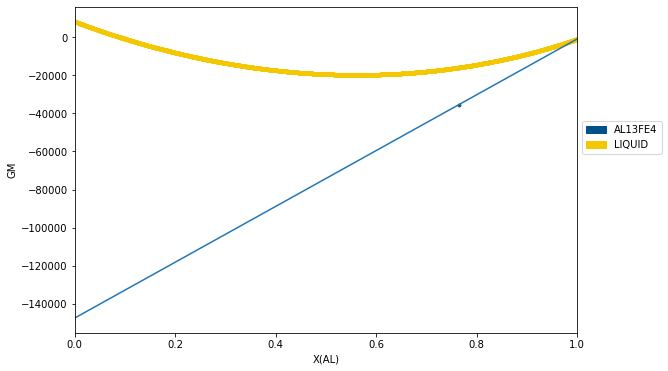

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
from pycalphad import Database, calculate, variables as v
from pycalphad.plot.utils import phase_legend
import numpy as np

# Get the colors that map phase names to colors in the legend
legend_handles, color_dict = phase_legend(['AL13FE4', 'LIQUID'])

fig = plt.figure(figsize=(9,6))
ax = fig.gca()

# Loop over phases, calculate the Gibbs energy, and scatter plot GM vs. X(RE)
for phase_name in ['AL13FE4', 'LIQUID']:
    result = calculate(dbf, ['AL', 'FE'], phase_name, P=101325, T=300, output='GM', model={'LIQUID': mod_liq})
    ax.scatter(result.X.sel(component='AL'), result.GM, marker='.', s=30, color=color_dict[phase_name])
plt.plot([1,0], chemical_potentials)
# Format the plot
ax.set_xlabel('X(AL)')
ax.set_ylabel('GM')
ax.set_xlim((0, 1))
ax.legend(handles=legend_handles, loc='center left', bbox_to_anchor=(1, 0.6))
plt.show()